In [1]:
import seaborn as sns


import os
from datetime import datetime
from collections import defaultdict
from itertools import islice
import random
import time
from pathlib import Path
import math

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm import tqdm, trange
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [2]:
from transformers import BartForConditionalGeneration, AutoTokenizer
base_model_name = 'facebook/bart-base'
model_name = 'SkolkovoInstitute/bart-base-detox'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
model.eval();

In [36]:
# str1 = 'now to digest it for you the above sentence ( quoted ) is downright stupid .'
str1 = 'its fucked up what your ugly stupid face looks like, fuck'
# str1 = 'strong fiscal management , my ass , steve o .'
# str1 = "i 'm ready to actually do something to make this shit stop , but what can i do ?"
# str1 = "holy shit that article was filled with ads "
# str1 = "come on ya fuckin dummy get your right step right ."
# str1 = "And why does this bother you, you motherfucker?"

tokenized = tokenizer(str1, return_tensors="pt")

In [37]:
with torch.no_grad():
    out = model(**tokenized)
    gen1 = model.generate(**tokenized)    
tokenizer.decode(gen1[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

"It's bad what your face looks like"

# Compare weight matrices of <u>pre-train</u> and <u>fine-tune</u>

In [ ]:
from transformers import BartTokenizer, BartModel

# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model_pretrain = BartModel.from_pretrained('facebook/bart-base')

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state


In [117]:
len(list(model.model.named_parameters())), len(list(model_pretrain.named_parameters()))

(259, 259)

In [243]:
def get_norms_layers_BART(model_1, model_2):
    dd_norms = {'decoder': {}, 'encoder':{}}
    for param_1, param_2 in tqdm(zip(model_1.named_parameters(), model_2.named_parameters())):
        name_1, w_1 = param_1
        name_2, w_2 = param_2

        w_1 = w_1.detach().cpu().numpy()
        w_2 = w_2.detach().cpu().numpy()

        assert name_1==name_2, f"Not equal names of modules \n{name_1}, \n{name_2}"
        if not (name_1 in ('shared.weight', 'encoder.embed_positions.weight', 'decoder.embed_positions.weight', \
                           'decoder.layernorm_embedding.weight', 'decoder.layernorm_embedding.bias')):
            assert (w_1.shape==w_2.shape), f"Not equal shapes of params \n{w_1.shape}, \n{w_2.shape}"

            if len(w_1.shape) == 1:
                divisor = np.sqrt(w_1.shape[0])
            elif len(w_1.shape) == 2:
                divisor = np.sqrt(w_1.shape[0] * w_1.shape[1])
            else:
                assert 0, "w_1.shape is not of len 1 or 2"

            part_name, _, num_layer, *param_name = name_1.split('.')
            param_name = '.'.join(param_name)

            if num_layer not in dd_norms[part_name]:
                dd_norms[part_name][num_layer] = {}
            dd_norms[part_name][num_layer][param_name] = np.linalg.norm((w_1-w_2), ord=2)/divisor
            
    return dd_norms

def plot_difference_norms(dd_norms, max_val_heatmap=None):
    mat_norms_enc = [[val for val in dd_norms['encoder'][str(i)].values()] for i in range(6)]
    labels_enc = [key for key in dd_norms['encoder'][str(0)].keys()] 

    mat_norms_dec = [[val for val in dd_norms['decoder'][str(i)].values()] for i in range(6)]
    labels_dec = [key for key in dd_norms['decoder'][str(0)].keys()] 
    
    if max_val_heatmap is None:
        max_val_heatmap = max(np.max(mat_norms_enc), np.max(mat_norms_dec))
    
    plt.figure(figsize=(12,3))
    sns.heatmap(mat_norms_enc, xticklabels=labels_enc, vmax=max_val_heatmap, cmap='summer')
    plt.show();

    plt.figure(figsize=(12,3))
    sns.heatmap(mat_norms_dec, xticklabels=labels_dec, vmax=max_val_heatmap, cmap='summer')
    plt.show();

Inspired by [1] M. Rofin, N. Balagansky, and D. Gavrilov, “Linear Interpolation In Parameter Space is Good Enough for Fine-Tuned Language Models.” arXiv, Nov. 22, 2022. doi: 10.48550/arXiv.2211.12092.

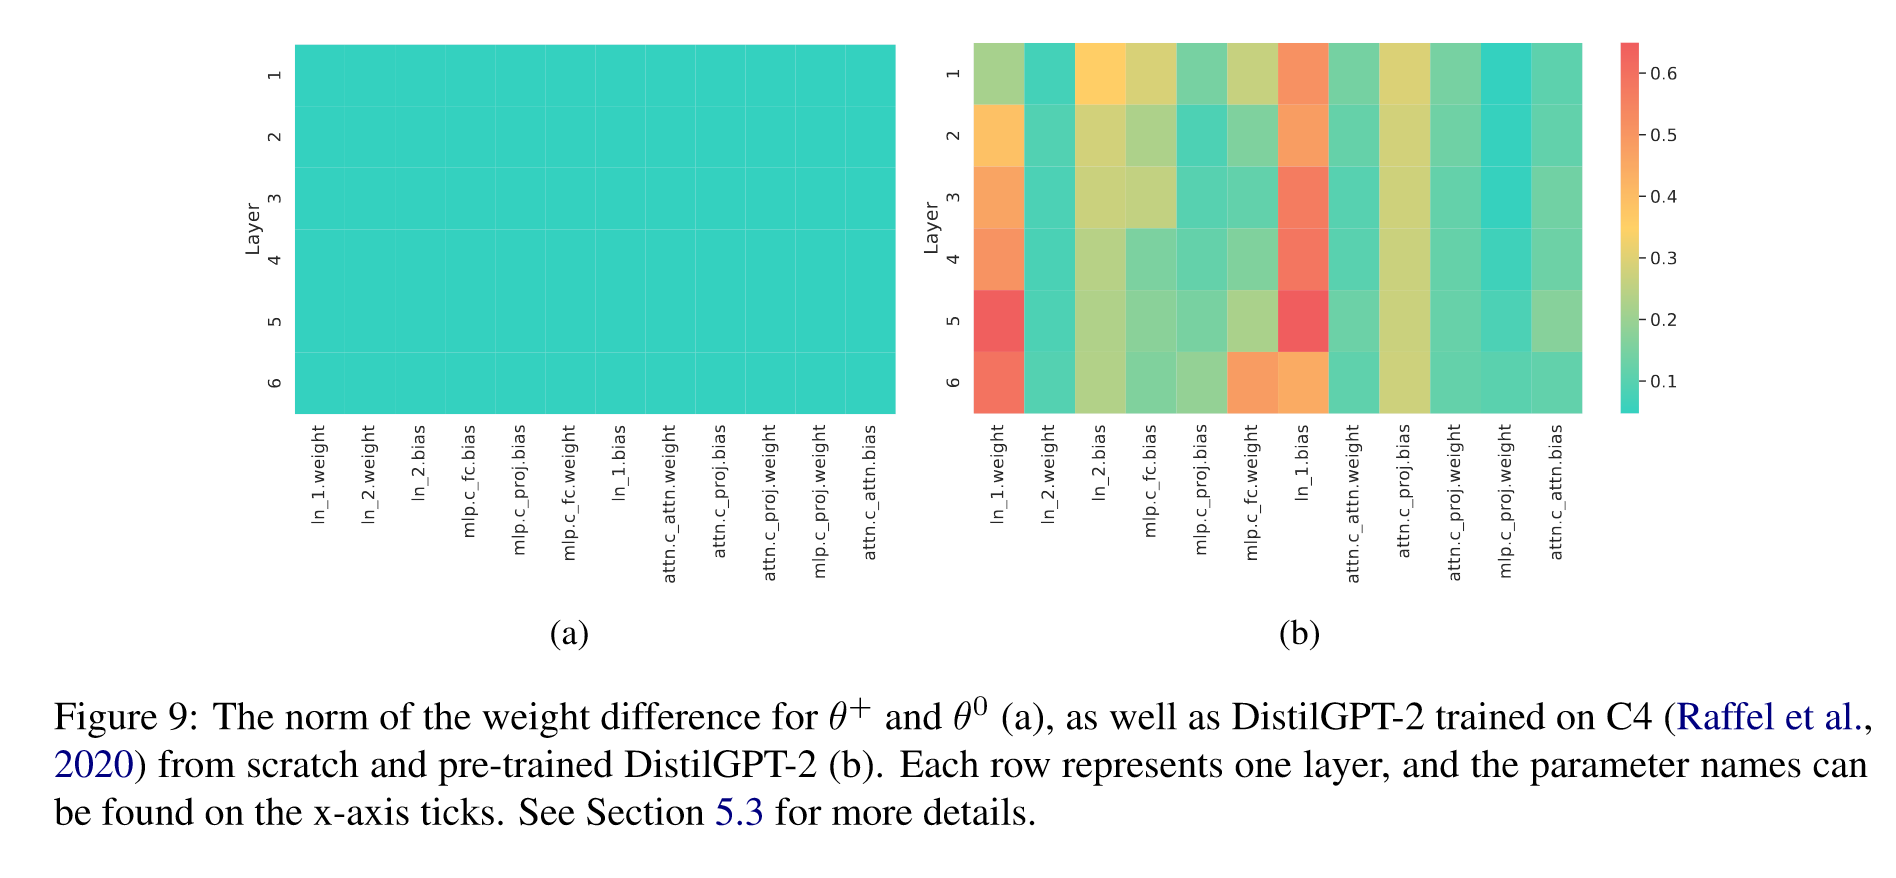

## Compare with another <u>pre-train</u> from HF

In [227]:
model_2 = BartModel.from_pretrained('fnlp/bart-base-chinese')

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

In [228]:
len(list(model_2.named_parameters())), len(list(model_pretrain.named_parameters()))

(259, 259)

In [232]:
dd_norms_pretrains = get_norms_layers_BART(model_2, model_pretrain)

259it [01:13,  3.53it/s]


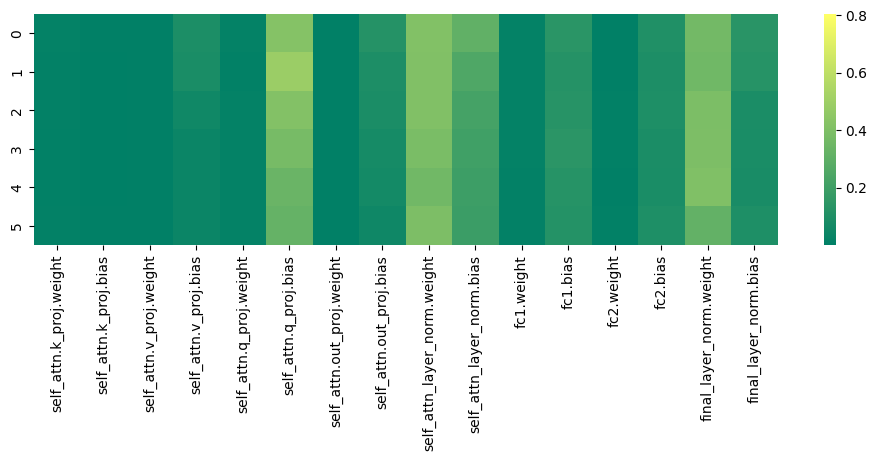

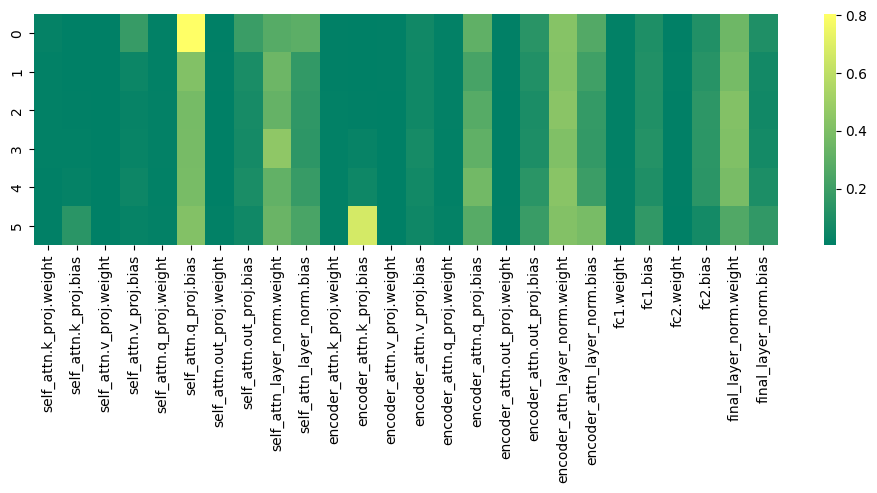

In [242]:
plot_difference_norms(dd_norms_pretrains)

## Compare with Detox <u>fine-tune</u>

259it [01:12,  3.56it/s]


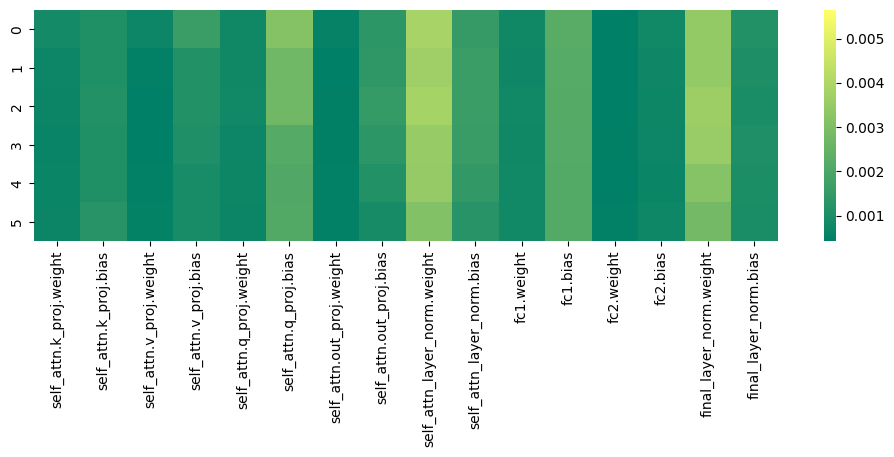

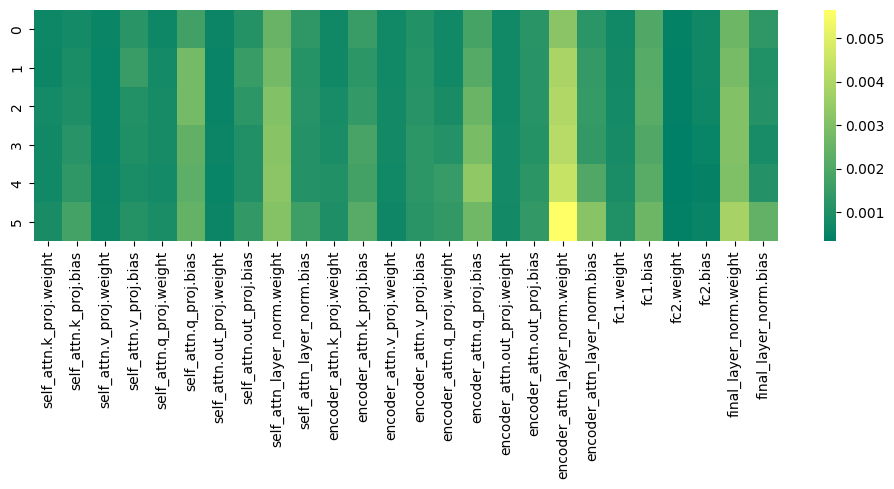

In [245]:
dd_norms = get_norms_layers_BART(model.model, model_pretrain)
plot_difference_norms(dd_norms)

### Same comparison but with the maximum hue value from the former <u>pre-train</u> comparison

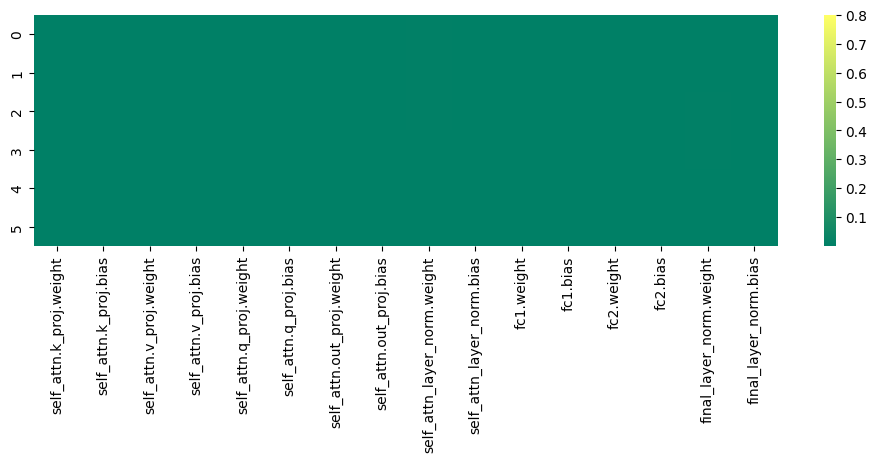

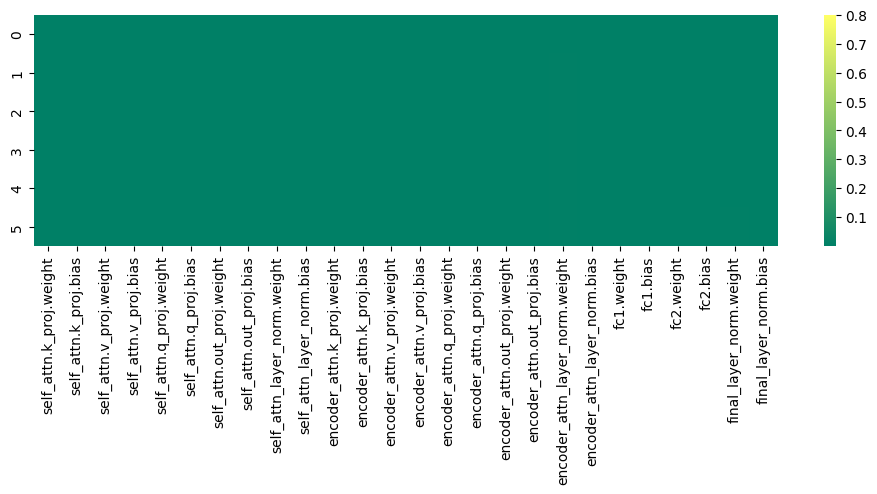

In [246]:
plot_difference_norms(dd_norms, max_val_heatmap=0.8)

# Rummaging in the layer weights in FFN

In [63]:
from transformers import BartForConditionalGeneration, AutoTokenizer
model_name = 'SkolkovoInstitute/bart-base-detox'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
model.eval();

base_model_name = 'facebook/bart-base'
base_model = BartForConditionalGeneration.from_pretrained(base_model_name)
base_model.eval();

> Let's recall the input sentence

In [144]:
str1 = 'its fucked up what your ugly stupid face looks like, fuck' 
str1 = 'its fucked up what your ugly stupid face' 
str1

'its fucked up what your ugly stupid face'

> Let's generate with the model

In [145]:
tokenized = tokenizer(str1, return_tensors="pt")

with torch.no_grad():
    out = model(
        **tokenized, 
        return_dict=True, 
        output_hidden_states=True, 
        output_attentions=True, 
        output_fc_activations=True # this is a custom param in my lib
    )
    
    base_out = base_model(
        **tokenized, 
        return_dict=True, 
        output_hidden_states=True, 
        output_attentions=True, 
        output_fc_activations=True # this is a custom param in my lib
    ) 

In [146]:
dd_str1 = {i:tokenizer.decode(token_) for i, token_ in enumerate(tokenized['input_ids'][0])}
dd_str1

{0: '<s>',
 1: 'its',
 2: ' fucked',
 3: ' up',
 4: ' what',
 5: ' your',
 6: ' ugly',
 7: ' stupid',
 8: ' face',
 9: '</s>'}

> Detox model output

In [147]:
dd_out_decoded = {i:tokenizer.decode(token_) for i, token_ in enumerate(out[0].argmax(axis=2)[0])}
dd_out_decoded

{0: '<s>',
 1: 'It',
 2: ' bad',
 3: ' up',
 4: ' what',
 5: ' your',
 6: ' face',
 7: ' face',
 8: ' face',
 9: '</s>'}

> Base model output

In [148]:
tokenizer.decode(base_model.generate(**tokenizer('I like <mask> fruits', return_tensors="pt"))[0])

'</s><s>I like my fruits</s>'

In [149]:
dd_out_decoded_base = {i:tokenizer.decode(token_) for i, token_ in enumerate(base_out[0].argmax(axis=2)[0])}
dd_out_decoded_base

{0: '<s>',
 1: 'its',
 2: ' fucked',
 3: ' up',
 4: ' what',
 5: ' your',
 6: ' ugly',
 7: ' stupid',
 8: ' face',
 9: '</s>'}

## Projecting hidden states

In [150]:
def get_list_projection_topk(tokenizer, projection, k, descending=True):
    projection_sorted = projection.argsort(descending=descending)
    list_top_decoded_proj = [tokenizer.decode(token_) for token_ in projection_sorted[:k]]
    return list_top_decoded_proj

### Decoder hidden states can show the path from original tokens to output

> Detox model

In [151]:
num_layers = len(out.decoder_hidden_states)
shape_hid = out.decoder_hidden_states[0].shape
for token_i in range(shape_hid[1]):
    for layer_i in range(num_layers):
        print(f"Token {token_i}, layer {layer_i}")
        projection_hid = model.lm_head(out.decoder_hidden_states[layer_i][0][token_i])
        top_hid = get_list_projection_topk(tokenizer, projection_hid, k=8, descending=True)
        print(top_hid)
    print()

Token 0, layer 0
['<s>', '</s>', 'Widget', 'rencies', ' ✓', '................', ' ---------', '$.']
Token 0, layer 1
['<s>', '+++', ' Unlock', ' Pastebin', 'ricular', 'XP', 'aldi', ' Instruct']
Token 0, layer 2
['<s>', 'worldly', 'daq', ' Pastebin', ' Authorization', ' (%)', 'oteric', ' ported']
Token 0, layer 3
['<s>', 'worldly', ' absor', 'volent', 'wolves', ' Authorization', ' (%)', 'soever']
Token 0, layer 4
['<s>', 'worldly', ' absor', ' Authorization', 'geries', ' (%)', 'volent', ' APPLIC']
Token 0, layer 5
['worldly', '<s>', 'volent', ' absor', ' (%)', 'nesses', ' thereof', ' implicated']
Token 0, layer 6
['<s>', 'You', 'that', 'It', 'That', 'I', 'If', 'The']

Token 1, layer 0
['<s>', '</s>', ' the', ' ✓', ',', 'uploads', ' and', 'rencies']
Token 1, layer 1
[' low', ' work', ' high', ' long', ' close', ' key', ' set', ' cost']
Token 1, layer 2
['<s>', ' low', ' been', ' generally', ' short', ' close', ' value', ' well']
Token 1, layer 3
[' by', '.', ' been', ' in', ' on', ' to',

> base model

In [152]:
num_layers = len(out.decoder_hidden_states)
shape_hid = out.decoder_hidden_states[0].shape
for token_i in range(shape_hid[1]):
    for layer_i in range(num_layers):
        print(f"Token {token_i}, layer {layer_i}")
        projection_hid = base_model.lm_head(base_out.decoder_hidden_states[layer_i][0][token_i])
        top_hid = get_list_projection_topk(tokenizer, projection_hid, k=8, descending=True)
        print(top_hid)
    print()

Token 0, layer 0
['<s>', '</s>', 'Widget', 'rencies', '................', ' ✓', ' ---------', '$.']
Token 0, layer 1
['<s>', ' Unlock', ' Pastebin', '+++', 'ricular', ' Ezek', ' Immunity', ' Instruct']
Token 0, layer 2
['<s>', 'worldly', 'daq', ' (%)', ' Authorization', ' Pastebin', 'oteric', 'fecture']
Token 0, layer 3
['<s>', 'worldly', ' absor', 'volent', 'wolves', 'icides', ' (%)', ' Authorization']
Token 0, layer 4
['<s>', 'worldly', ' absor', ' (%)', ' Authorization', 'volent', 'geries', 'nesses']
Token 0, layer 5
['worldly', '<s>', ' absor', 'volent', 'nesses', ' (%)', ' implicated', 'sic']
Token 0, layer 6
['<s>', ' circumcised', ' vetoed', 'Daddy', ' hatched', ' debunked', ' mortg', ' ridic']

Token 1, layer 0
['<s>', '</s>', '................', ' ✓', 'uploads', ' the', 'rencies', 'Widget']
Token 1, layer 1
[' low', ' work', ' key', ' high', ' close', ' cost', ' short', ' long']
Token 1, layer 2
['<s>', ' been', ' generally', ' short', ' broader', ' low', ' close', ' value']
T

### Encoder hidden states' projections are mostly not changed

In [153]:
hid_states = out.encoder_hidden_states
num_layers = len(out.encoder_hidden_states)
shape_hid = hid_states[0].shape

with torch.no_grad():
    for token_i in range(shape_hid[1]):
        for layer_i in range(num_layers):
            print(f"Token {token_i}, layer {layer_i}")
            projection_hid = model.lm_head(hid_states[layer_i][0][token_i])
            top_hid = get_list_projection_topk(tokenizer, projection_hid, k=8, descending=True)
            print(top_hid)
        print()

Token 0, layer 0
['<s>', '<mask>', 'mma', 'zer', 'xa', 'Reviewer', ' GOODMAN', 'Topics']
Token 0, layer 1
['<s>', 'alg', ' GOODMAN', 'rencies', 'bral', 'kai', 'kas', ' spoil']
Token 0, layer 2
['<mask>', ',', '.', ' was', ' in', '-', ' a', ' the']
Token 0, layer 3
['<mask>', ',', '.', ' was', ' in', '-', ' a', ' the']
Token 0, layer 4
['<mask>', '.', ',', ' was', ' in', ' a', '-', '"']
Token 0, layer 5
['<mask>', '.', ',', ' was', ' in', '"', '-', ' a']
Token 0, layer 6
['<mask>', '<s>', '.', 'roup', ' was', ',', 'essional', '-']

Token 1, layer 0
['its', 'ITS', 'it', 'iting', 'ited', 'itted', 'itting', 'Its']
Token 1, layer 1
['its', 'ITS', 'Its', ' its', ' Its', ' ITS', 'it', 'iting']
Token 1, layer 2
['its', 'Its', ' its', ' Its', ' ITS', 'ITS', 'it', ' whats']
Token 1, layer 3
['its', 'Its', ' its', ' Its', 'ITS', ' ITS', ' whats', 'IT']
Token 1, layer 4
['its', 'Its', 'It', ' its', 'it', ' Its', ' it', ' whats']
Token 1, layer 5
['its', 'Its', 'It', ' its', ' whats', ' Its', ' it'

## Consider memory cells (despite GeLU activation) of the Detox BART model for the token `fucked` at position `2`

In [154]:
out.keys()

odict_keys(['logits', 'past_key_values', 'decoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions', 'fc1_activations', 'fc2_activations'])

### Base model sorted fc1_activations

In [213]:
with torch.no_grad():
    q = (base_out.fc2_activations[-1])
    q = base_model.model.decoder.layers[-1].final_layer_norm(q)
    q = base_model.model.decoder.layernorm_embedding(q)
    q = base_model.lm_head(q)
q[0][2].sort()

torch.return_types.sort(
values=tensor([-4.1711, -4.0898, -4.0311,  ...,  4.3756,  4.4998,  4.5963]),
indices=tensor([ 8387, 26193, 47583,  ..., 19656, 42730, 42647]))

In [243]:
# base_model pred from last layer fc2
tokenizer.decode(42647)

' fucked'

> Scooching the activation with the detox model's activated neurons

In [ ]:
# # for reproducing 
# with torch.no_grad():
#     q = (base_out.fc1_activations[-1])
#     q = base_model.model.decoder.layers[-1].activation_fn(q)
#     q = base_model.model.decoder.layers[-1].fc2(q)
#     q = base_model.model.decoder.layers[-1].final_layer_norm(q)
#     q = base_model.model.decoder.layernorm_embedding(q)
#     q = base_model.lm_head(q)
# q[0][2].sort()

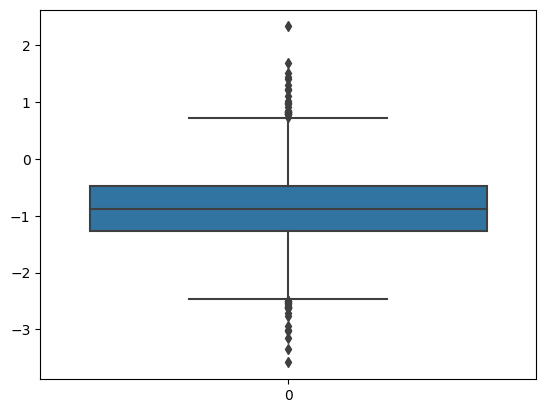

In [234]:
sns.boxplot((base_out.fc1_activations[-1])[0][2].numpy())
plt.show()

Let's choose the value of 3, which was designated high even in the original paper by Geva et al.

In [288]:
with torch.no_grad():
    q = (base_out.fc1_activations[-1])
    q[0, 2, 2295] = 3 # scooching 
    
    q = base_model.model.decoder.layers[-1].activation_fn(q)
    q = base_model.model.decoder.layers[-1].fc2(q)
    q = base_model.model.decoder.layers[-1].final_layer_norm(q)
    q = base_model.model.decoder.layernorm_embedding(q)
    q = base_model.lm_head(q)
q[0][2].sort()

torch.return_types.sort(
values=tensor([-4.6057, -4.3556, -4.3033,  ...,  4.3501,  4.5284,  5.1026]),
indices=tensor([27463, 12487, 37739,  ..., 39018, 42538, 42647]))

The direct outcome of activating neuron_id = 2295 is suppressing the tokens like 'cool'. This is done surely but not the desired token promotion.

In [289]:
# base_model pred from last layer fc2 after modifying the layer activations
tokenizer.decode(([27463, 12487, 37739, 39018, 42538, 42647]))

' proponents CoolCool dism dw fucked'

> Looking at the top neurons

In [156]:
with torch.no_grad():
    num_layers = base_out.fc1_activations.__len__()
    num_tokens = base_out.fc1_activations[0].shape[1]

    token_id = 2
    ith_best_neuron = 0

    
    for layer_i in range(num_layers):
        layer_id = layer_i
        top_k = 20

        print('-'*50)
        print(f"Layer index {layer_id}/{num_layers-1}, Token {token_id}/{num_tokens}, Top {ith_best_neuron}th memory")

        # Turn on or off activation function
#         mem_cell_id = F.gelu(base_out.fc1_activations[layer_id][0][token_id]).argsort(descending=True)[ith_best_neuron]
        mem_cell_id = (base_out.fc1_activations[layer_id][0][token_id]).argsort(descending=True)[ith_best_neuron]
        mem_cell_id = 1711
        
        fc1_layer_w = base_model.model.decoder.layers[layer_id].fc1.weight.detach()
        fc2_layer_w = base_model.model.decoder.layers[layer_id].fc2.weight.detach()

        n_look = fc1_layer_w[mem_cell_id]
        n_induce = fc2_layer_w[:,mem_cell_id]

        projection_look = base_model.lm_head(n_look)
        projection_induce = base_model.lm_head(n_induce)

        top_look = get_list_projection_topk(tokenizer, projection_look, top_k, descending=True)
        top_induce = get_list_projection_topk(tokenizer, projection_induce, top_k, descending=True)
        print('-'*10)
        print('From TOP order')
        print(f'Top {top_k} tokens for looking')
        print(f"[{', '.join(top_look)}]")
        print(f'Top {top_k} tokens for inducing')
        print(f"[{', '.join(top_induce)}]")


        top_look = get_list_projection_topk(tokenizer, projection_look, top_k, descending=False)
        top_induce = get_list_projection_topk(tokenizer, projection_induce, top_k, descending=False)
        print('-'*10)
        print('From BOTTOM order')
        print(f'Top {top_k} tokens for looking')
        print(f"[{', '.join(top_look)}]")
        print(f'Top {top_k} tokens for inducing')
        print(f"[{', '.join(top_induce)}]")
        
        print()


--------------------------------------------------
Layer index 0/5, Token 2/10, Top 0th memory
----------
From TOP order
Top 20 tokens for looking
[ Unless, ubi,  disl,  feeble,  nons,  Higgins, weak, excluding,  h,  Preferences,  Contrary, Unless, leans,  incl, suff,  RH,  protr,  remainder,  LOW,  merely]
Top 20 tokens for inducing
[ humane, inion,  Claudia, …), ickey, asty, iguous,  Helena,  Humane,  Condition,  Natalie, IG,  opinion, .):,  rated,  objectively,  REL, ENS, ort, OL]
----------
From BOTTOM order
Top 20 tokens for looking
[ marsh,  Enough,  ourselves, ign,  enough, mic,  sandbox, Register, bal, igated,  the, add, deck, wall,  Bal, ac,  Chess,  our,  their, ancer]
Top 20 tokens for inducing
[listed, named, xs, stocks,  altar, baum,  accounting, cade,  dishes, ck,  Maw, once,  wheel, confirmed,  Soup, bus,  towers,  trenches,  Ware,  SQU]

--------------------------------------------------
Layer index 1/5, Token 2/10, Top 0th memory
----------
From TOP order
Top 20 tokens

### Detox model sorted fc1_activations

In [157]:
(out.fc1_activations[layer_id][0][token_id]).argsort(descending=False), \
(out.fc1_activations[layer_id][0][token_id]).sort()

(tensor([1960,  852, 1489,  ...,  731, 1711, 2295]),
 torch.return_types.sort(
 values=tensor([-3.6387, -3.5099, -3.4274,  ...,  1.0900,  1.1536,  1.4210]),
 indices=tensor([1960,  852, 1489,  ...,  731, 1711, 2295])))

In [160]:
with torch.no_grad():
    num_layers = out.fc1_activations.__len__()
    num_tokens = out.fc1_activations[0].shape[1]

    token_id = 2
    ith_best_neuron = 0 # 0

    
    for layer_i in range(num_layers):
        layer_id = layer_i
        top_k = 12

        print('-'*50)
        print(f"Layer index {layer_id}/{num_layers-1}, Token {token_id}/{num_tokens}, Top {ith_best_neuron}th activated neuron/memory")

        # Turn on or off activation function
#         mem_cell_id = F.gelu(out.fc1_activations[layer_id][0][token_id]).argsort(descending=True)[ith_best_neuron]
        mem_cell_id = (out.fc1_activations[layer_id][0][token_id]).argsort(descending=True)[ith_best_neuron]
        
        fc1_layer_w = model.model.decoder.layers[layer_id].fc1.weight.detach()
        fc2_layer_w = model.model.decoder.layers[layer_id].fc2.weight.detach()

        n_look = fc1_layer_w[mem_cell_id]
        n_induce = fc2_layer_w[:,mem_cell_id]

        projection_look = model.lm_head(n_look)
        projection_induce = model.lm_head(n_induce)

        top_look = get_list_projection_topk(tokenizer, projection_look, top_k, descending=True)
        top_induce = get_list_projection_topk(tokenizer, projection_induce, top_k, descending=True)
        print('-'*10)
        print('From TOP - order')
        print(f'Top {top_k} tokens for looking')
        print(f"[{', '.join(top_look)}]")
        print(f'Top {top_k} tokens for inducing')
        print(f"[{', '.join(top_induce)}]")


        top_look = get_list_projection_topk(tokenizer, projection_look, top_k, descending=False)
        top_induce = get_list_projection_topk(tokenizer, projection_induce, top_k, descending=False)
        print('-'*10)
        print('From BOTTOM (negative impact) - order')
        print(f'Top {top_k} tokens for looking')
        print(f"[{', '.join(top_look)}]")
        print(f'Top {top_k} tokens for inducing')
        print(f"[{', '.join(top_induce)}]")
        
        print()


--------------------------------------------------
Layer index 0/5, Token 2/10, Top 0th activated neuron/memory
----------
From TOP - order
Top 12 tokens for looking
[terday, wolf, audi, onsense, bsite, stats, gins, tips, votes, fights, john, policy]
Top 12 tokens for inducing
[fore, care,  eas, expl, ging, bare, mosp, aging,  rom, cm,  blu,  meter]
----------
From BOTTOM (negative impact) - order
Top 12 tokens for looking
[Va, O, E, Tra,  such,  even, Led, P, Ari, Ret, W,  there]
Top 12 tokens for inducing
[ Citizenship,  Pieces,  Buffer,  Crusher,  Piece,  Passage,  Steps,  Exposure, arov,  Principles,  Errors,  Sweeney]

--------------------------------------------------
Layer index 1/5, Token 2/10, Top 0th activated neuron/memory
----------
From TOP - order
Top 12 tokens for looking
[ NEC, amar, ties, rises, KK, edes, seless, zik, zza, LESS, anium, pes]
Top 12 tokens for inducing
[ained, atis, roe, ains,  raining,  dawn,  incumbent,  Koch, aining, dam,  pains,  theirs]
----------
F

> Surprisingly, the inducing projection of the last layer in the decoder part, 5/5, makes more sense in ascending order. As if the prediction is built by pushing away from the non-apposite concepts.